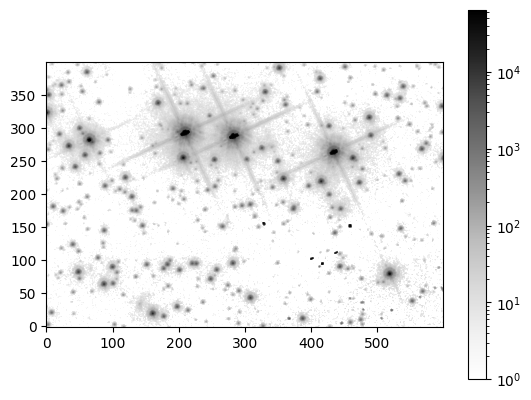

In [1]:
'''code carried over from L1_fits-handling.ipynb'''

# open fits file and extract data
from astropy.io import fits
fits_file = fits.open('ngc1261.fits')
image_data = fits_file[0].data

# define section1 (the portion of the image that we will work with)
section1 = image_data[2250:2650, 5350:5950]

# plot section 1
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.figure()
plt.imshow(section1, origin = 'lower', cmap = 'Greys', norm = LogNorm())
plt.colorbar()
plt.show()

In [2]:
'''find mean, median, and standard deviation'''

from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(section1,sigma=3.0)
# print data
print((mean,median,std))

(1.6487273, 0.0, 8.310026)


In [3]:
'''Use DAOStarFinder to detect stars'''

from photutils.detection import DAOStarFinder

# find stars that have a full-width-half-maximum of about 3 pixels and
# are at least 5 sigma above the background level
daofind = DAOStarFinder(fwhm = 3.0, threshold = 5.0*std)

# define table named "sources"
sources = daofind(section1 - median)

# format sources table
for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'

# print table (make sure to use 'p-print' not just 'print')
sources.pprint(max_width = 76)

 id xcentroid ycentroid sharpness roundness1 ... sky    peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ----- -----
  1    117.20      0.34      0.88      -0.20 ... 0.00  199.00  3.38 -1.32
  2    428.44      0.36      0.77      -0.29 ... 0.00  168.00  2.93 -1.17
  3    327.47      1.06      0.51       0.02 ... 0.00  619.00 13.01 -2.79
  4      2.78      3.20      0.49      -0.01 ... 0.00  660.00 13.98 -2.86
  5    103.18      3.44      0.66       0.10 ... 0.00  407.00  7.17 -2.14
  6    477.76      3.68      0.59       0.00 ... 0.00  258.00  4.72 -1.68
  7    290.51      5.25      0.46       0.19 ... 0.00  302.00  6.52 -2.04
  8    446.31      5.24      0.77       0.39 ... 0.00 1772.00 33.91 -3.83
  9    459.62      6.53      0.70       0.45 ... 0.00  960.00 15.98 -3.01
 10    241.68      7.76      0.53       0.21 ... 0.00  113.00  2.45 -0.97
...       ...       ...       ...        ... ...  ...     ...   ...   ...
409    496.71    392.87      0.53     

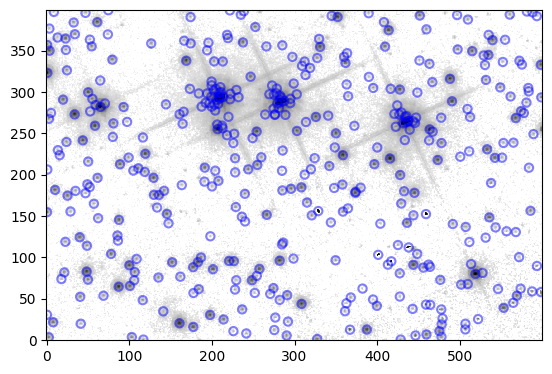

In [4]:
'''visualize detected stars with matplotlib'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture

# define star positions based on sources table, then draw 
# apertures around each position (radius 5) and plot data
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r = 5.0)
plt.imshow(section1, cmap = 'Greys', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')

# draw apertures. apertures.plot command takes arguments (color, line-width, and opacity (alpha))
apertures.plot(color = 'blue', lw = 1.5, alpha = 0.5);

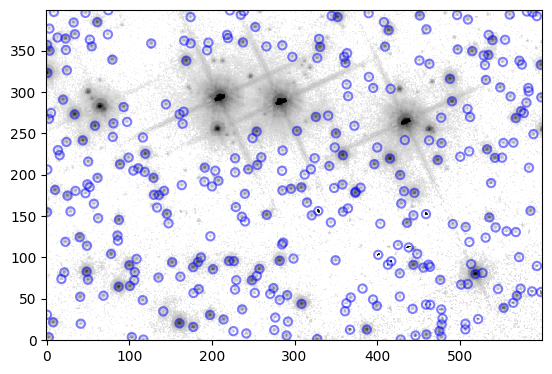

In [12]:
'''Mask regions with bright stars'''

mask = np.zeros(section1.shape, dtype=bool)

# select regions to mask (y:y,x:x)
mask[260:320,40:80] = True
mask[230:350,170:240] = True
mask[260:340,240:320] = True
mask[250:330,420:470] = True

# redefine sources table
sources = daofind(section1-median,mask=mask)
xpix = sources['xcentroid']
ypix = sources['ycentroid']

# plot new table
positions = np.transpose((xpix,ypix))
apertures = CircularAperture(positions,r=5.0)
plt.imshow(section1, cmap='Greys', norm=LogNorm(), origin = 'lower', interpolation='nearest')
apertures.plot(color='blue',lw=1.5, alpha = 0.5);

In [6]:
'''use find_peaks to detect stars'''

from astropy.stats import sigma_clipped_stats
from photutils.detection import find_peaks

# define mean, median, and std
mean, median, std = sigma_clipped_stats(section1, sigma = 3.0)

# find stars that are at least 5 sigma above background and 
# separated by at least 5 pixels
threshold = median + (5.0*std)

# define, format, and print table of peak values
tbl = find_peaks(section1, threshold, box_size = 11)
tbl['peak_value'].info.format = '%8g'
print(tbl)

x_peak y_peak peak_value
------ ------ ----------
   117      0        199
   428      0        168
   327      1        656
     3      3        660
   103      3        407
   291      5        318
   446      5       1772
   460      7        960
   242      8        113
   226     10         66
   ...    ...        ...
   235    394         87
    47    395        110
   390    395        105
   482    395         43
   258    396         47
   588    396        146
     9    397         70
   581    397        122
    75    399         93
   170    399        104
   222    399        114
Length = 530 rows


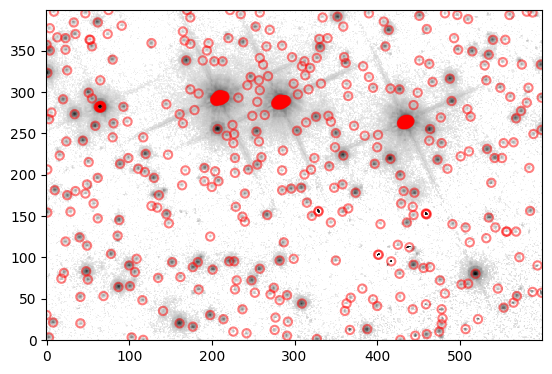

In [14]:
'''visualize locations of detected peaks with matplotlib'''

# define positions based on peak table and plot data
peak_positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
plt.imshow(section1, cmap = 'Greys', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')

# plot peak apertures
peak_apertures = CircularAperture(peak_positions, r = 5.0)
peak_apertures.plot(color = 'red', lw = 1.5, alpha = 0.5);